## Brain CT classification based on level of infection

### Loading the dataset

In [3]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 870.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00


In [1]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 16.4 MB/s eta 0:00:00


In [4]:
# Importing the neccessary libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

import cv2
import os

In [5]:
# mount gdrive to load the zip file from google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!cp '/content/drive/My Drive/Dataset.zip' 'Dataset.zip'

In [7]:
!unzip -q Dataset.zip

In [8]:
import scipy.io as sio

# Load the .mat file
mat_contents = sio.loadmat('/content/Dataset/Train.mat')

# # Access the data
data = mat_contents['data']
label = mat_contents['label']
label = label.flatten()

print(data.shape)
print(label.shape)

(2558, 224, 224)
(2558,)


In [9]:
unique_labels, label_counts = np.unique(label, return_counts=True)
print(label_counts)

[1038 1406  114]


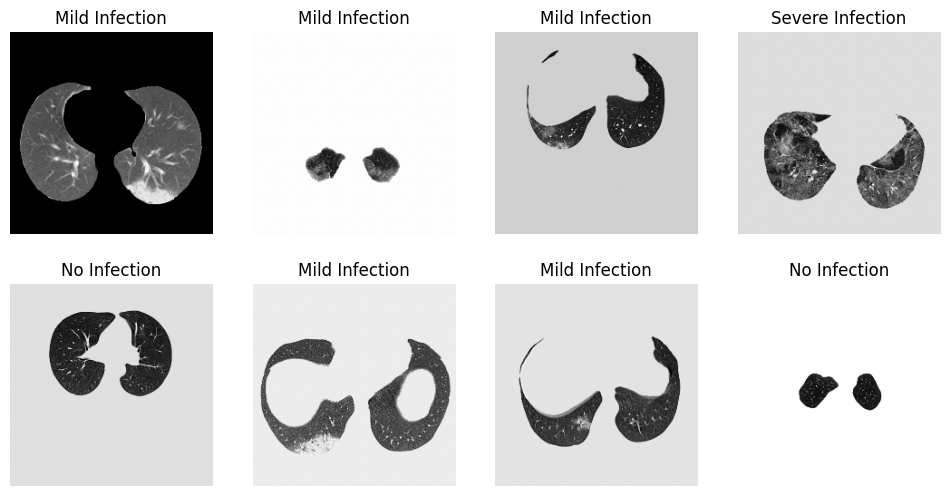

In [10]:
import matplotlib.pyplot as plt

# Select 8 images and their corresponding titles
num_images = 8
images = data[:num_images]
titles = label[:num_images]
word_title = []
for i in titles:
  if i == 0:
    word_title.append('No Infection')
  elif i == 1:
    word_title.append('Mild Infection')
  elif i == 2:
    word_title.append('Severe Infection')

# Create a figure and axes for the subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # Adjust figsize as needed

# Iterate through images and plot them with titles
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')  # Assuming grayscale images
    ax.set_title(str(word_title[i]))  # Convert title to string if necessary
    ax.axis('off')  # Remove axis ticks and labels


# Display the plot
plt.show()

#### One-hot encoding the labels

In [11]:
# One hot encoding of labels
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(label.reshape(-1, 1))
print(one_hot_encoded.shape)

(2558, 3)


#### Creating tensors for training and validation




In [12]:
batch_size = 32

# Resizing the data so that channel information is also captured
data = data.reshape(data.shape[0], data.shape[1], data.shape[2], 1)

# Reshape data if not already in (224, 224, 1)
data = data.reshape(-1, 224, 224, 1)

# Create a TensorFlow dataset
train_data = tf.data.Dataset.from_tensor_slices((data, one_hot_encoded))



# Apply batching, shuffling, and prefetching
train_data = train_data.batch(batch_size, drop_remainder=True).cache().shuffle(buffer_size=500).prefetch(tf.data.AUTOTUNE)

In [13]:
for batch in train_data.take(10):
    images, labels = batch
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)


In [14]:
# Load the .mat file
val_contents = sio.loadmat('/content/Dataset/Val.mat')

# # Access the data
val_data = val_contents['data']
val_label = val_contents['label']
val_label = val_label.flatten()


In [15]:
# One hot encoding of labels
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
val_target = encoder.fit_transform(val_label.reshape(-1, 1))


In [17]:
# Resizing the data so that channel information is also captured
val_data = val_data.reshape(val_data.shape[0], val_data.shape[1], val_data.shape[2], 1)

val_data = val_data.reshape(-1, 224, 224, 1)

# Create a TensorFlow dataset
val_data = tf.data.Dataset.from_tensor_slices((val_data, val_target))

# Apply batching, shuffling, and prefetching
val_data = val_data.batch(batch_size,drop_remainder=True).cache().shuffle(buffer_size=500).prefetch(tf.data.AUTOTUNE)

In [18]:
for batch in val_data.take(1):
    images, labels = batch
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)


### Building the classification model

In [19]:
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Sequential
from keras.layers import BatchNormalization
from tensorflow.keras import layers, regularizers

# Define the L2 regularization factor
l2_factor = 0.0001

In [20]:
# Initialising the CNN
model = Sequential()

# first add a separate input layer
model.add(keras.layers.Input(shape=(224, 224, 1)))

# Adding first convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(l2_factor)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Adding a second convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation = 'relu',kernel_regularizer=regularizers.l2(l2_factor)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Adding a third convolutional layer
model.add(layers.Conv2D(256, (3, 3), activation = 'relu',kernel_regularizer=regularizers.l2(l2_factor)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Adding a fourth convolutional layer
model.add(layers.Conv2D(512, (3, 3), activation = 'relu',kernel_regularizer=regularizers.l2(l2_factor)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Adding a fifth convolutional layer
model.add(layers.Conv2D(1024, (3, 3), activation = 'relu',kernel_regularizer=regularizers.l2(l2_factor)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.1))

# Flattening
model.add(layers.Flatten())
model.add(layers.Dropout(0.1))

# Full connection
model.add(layers.Dense(units = 512, activation = 'relu',kernel_regularizer=regularizers.l2(l2_factor)))
model.add(layers.Dropout(0.3))


model.add(layers.Dense(3, activation='softmax'))



In [21]:
# Generate summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 26, 26, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 1024)        │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 5, 5, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      13,107,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,378,691 (73.92 MB)

 Trainable params: 19,378,691 (73.92 MB)

 Non-trainable params: 0 (0.00 B)

#### Defining loss functions & Compiling the model

In [22]:
!pip install keras-cv
import keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 30.5 MB/s eta 0:00:00


In [23]:
# Compiling the model
model.compile(loss=keras_cv.losses.FocalLoss(from_logits=False, gamma=3.0),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics = ['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

#### Fitting the model with callback functions

In [24]:
history = model.fit(train_data,epochs = 10, validation_data = val_data)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 795s 10s/step - acc: 0.5292 - auc: 0.7548 - loss: 0.2877 - precision: 0.6237 - recall: 0.0229 - val_acc: 0.7383 - val_auc: 0.8816 - val_loss: 0.2214 - val_precision: 0.9394 - val_recall: 0.1211
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 784s 10s/step - acc: 0.7292 - auc: 0.8915 - loss: 0.2039 - precision: 0.8839 - recall: 0.3411 - val_acc: 0.7969 - val_auc: 0.9183 - val_loss: 0.1724 - val_precision: 0.9506 - val_recall: 0.3008
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 783s 10s/step - acc: 0.8047 - auc: 0.9338 - loss: 0.1582 - precision: 0.9091 - recall: 0.5224 - val_acc: 0.8398 - val_auc: 0.9536 - val_loss: 0.1385 - val_precision: 0.9685 - val_recall: 0.4805
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 783s 10s/step - acc: 0.8424 - auc: 0.9591 - loss: 0.1304 - precision: 0.9232 - recall: 0.6708 - val_acc: 0.8867 - val_auc: 0.9661 - val_loss: 0.1250 - val_precision: 0.9915 - val_recall: 0.4531
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 780s 10s/step - acc: 0.8682 - auc:

### Model performance

In [25]:
# Defining a function to extract history from the model and plot the metrics as graphs

def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

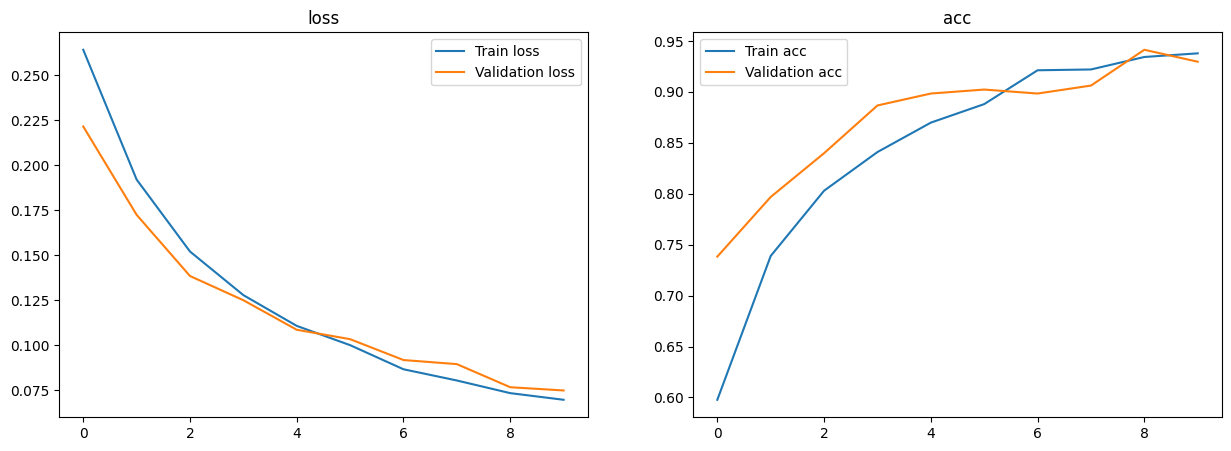

In [26]:
# Plotting the graphs of variation of training metrics over epochs

show_history(history)

In [27]:
# save model
model.save('classification.keras')

####Evaluating model performance over test data

In [28]:
# load the saved model from desktop in case runtime gets disconnected ; Otherwise you can skip this cell

model = tf.keras.models.load_model('classification.keras')

In [29]:
import scipy.io as sio

# Load the .mat file
test_contents = sio.loadmat('/content/Dataset/Test.mat')

# # Access the data
test_data = test_contents['data']
test_label = test_contents['label']
test_label = test_label.flatten()

In [30]:
# One hot encoding of labels
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the categorical columns
test_target = encoder.fit_transform(test_label.reshape(-1, 1))

In [31]:
batch_size = 32

# Resizing the data so that channel information is also captured
test_dataset = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1)

test_dataset = test_dataset.reshape(-1, 224, 224, 1)

# Create a TensorFlow dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_dataset, test_target))

# Apply batching, shuffling, and prefetching
test_dataset = test_dataset.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

In [32]:
for batch in test_dataset.take(10):
    images, labels = batch
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)
Image batch shape: (32, 224, 224, 1)
Label batch shape: (32, 3)


In [33]:
# Evaluate the model on the test dataset and print out the accuracy and loss
test_loss, test_accuracy,test_auc,test_precision,test_recall = model.evaluate(test_dataset)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test AUC:{test_auc:.4f}')
print(f'Test Recall:{test_recall:.4f}')
print(f"Test precision:{test_precision:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - acc: 0.9407 - auc: 0.9916 - loss: 0.0683 - precision: 0.9754 - recall: 0.9000
Test Loss: 0.0693
Test Accuracy: 0.9466
Test AUC:0.9728
Test Recall:0.9909
Test precision:0.9058


Getting a classification report on the test dataset

In [34]:
pred_probs = model.predict(test_dataset)

# print(pred_probs)
# print(test_target)

# Convert probabilities to binary predictions using a threshold of 0.5
predicted_labels = (pred_probs > 0.5).astype(int)

from sklearn.metrics import classification_report

true_labels = test_target

# Get classification reports
report1 = classification_report(true_labels, predicted_labels, target_names=["No infection", "Mild infection","Severe infection"])


print("Classification Report for Test Dataset:\n", report1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
Classification Report for Test Dataset:
                   precision    recall  f1-score   support

    No infection       0.95      0.91      0.93       288
  Mild infection       0.99      0.92      0.95       391
Severe infection       0.96      0.75      0.84        32

       micro avg       0.97      0.91      0.94       711
       macro avg       0.97      0.86      0.91       711
    weighted avg       0.97      0.91      0.94       711
     samples avg       0.91      0.91      0.91       711



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Plotting a confusion matrix to visually understand the results

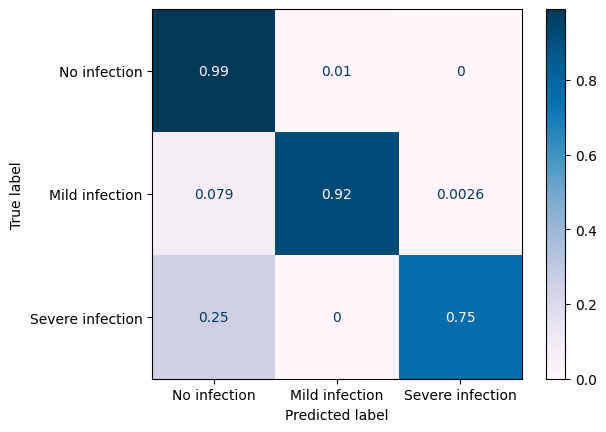

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# converting true and predicted labels into single int instead of one-hot encoding
predicted_labels_single = np.argmax(predicted_labels, axis=1)  # Gets index of max value in each row
true_labels_single = np.argmax(true_labels, axis=1)

# print(predicted_labels_single)
# print(true_labels_single)


cm = confusion_matrix(true_labels_single,predicted_labels_single, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No infection", "Mild infection","Severe infection"])
disp.plot(cmap="PuBu")
plt.show()
